# 📊 Optimización de Portafolio con Machine Learning

Este notebook implementa un sistema de optimización de portafolio que combina:
- **Mean-Variance Optimization** (Markowitz)
- **Machine Learning** (XGBoost) para predicciones
- **Black-Litterman Model** para ajustar expectativas

## 🎯 Objetivo
Comparar 3 estrategias:
1. Portafolio original (sin optimizar)
2. Optimización Mean-Variance clásica
3. Optimización ML + Mean-Variance

---

## ⚠️ IMPORTANTE: Reiniciar Kernel
Si has modificado algún archivo `.py`, debes **reiniciar el kernel** para que los cambios se apliquen:
- **VS Code**: Haz clic en "Restart" en la parte superior del notebook
- **Jupyter**: Kernel → Restart

---

## 1️⃣ Importar Librerías

Importamos todos los módulos necesarios para el análisis.

In [1]:
import mean_variance_optimization as mv
import machine_learning_strategies as mls
import black_litterman_model as bl
import portfolio_statistics as ps
import factor_analysis as fa   # For future use

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [2]:
# Verificar que TODOS los módulos tengan auto_adjust=False
import inspect

print("🔍 VERIFICACIÓN DE TODOS LOS MÓDULOS\n")

# Lista de módulos y funciones a verificar
checks = [
    (mv, 'download_stock_data', 'mean_variance_optimization'),
    (mls, 'generate_investor_views', 'machine_learning_strategies'),
    (fa, 'download_stock_data', 'factor_analysis'),
]

all_good = True

for module, func_name, module_name in checks:
    if hasattr(module, func_name):
        source = inspect.getsource(getattr(module, func_name))
        
        if "auto_adjust=False" in source:
            print(f"✅ {module_name}.{func_name} tiene auto_adjust=False")
        else:
            print(f"❌ {module_name}.{func_name} NO tiene auto_adjust=False")
            all_good = False
    else:
        print(f"⚠️ {module_name}.{func_name} no encontrada")

print("\n" + "="*70)
if all_good:
    print("✅ TODOS LOS MÓDULOS ESTÁN CORRECTOS")
else:
    print("❌ ALGUNOS MÓDULOS NECESITAN auto_adjust=False")
    print("   Ejecuta la celda de 'Forzar Recarga de Módulos' (siguiente celda)")
print("="*70)

# Hacer una prueba rápida
print("\n🧪 Prueba rápida descargando SPY:")
test_data = mv.download_stock_data(['SPY'], '2023-01-01', '2023-01-10')
print(f"Columnas disponibles: {test_data.columns.tolist()[:5]}...")

if isinstance(test_data.columns, pd.MultiIndex):
    print("Tipo: MultiIndex")
    if 'Adj Close' in test_data.columns.levels[0]:
        print("✅ 'Adj Close' está disponible")
    else:
        print("❌ 'Adj Close' NO está disponible")
else:
    if 'Adj Close' in test_data.columns:
        print("✅ 'Adj Close' está disponible")
    else:
        print("❌ 'Adj Close' NO está disponible")

🔍 VERIFICACIÓN DE TODOS LOS MÓDULOS

✅ mean_variance_optimization.download_stock_data tiene auto_adjust=False
❌ machine_learning_strategies.generate_investor_views NO tiene auto_adjust=False
✅ factor_analysis.download_stock_data tiene auto_adjust=False

❌ ALGUNOS MÓDULOS NECESITAN auto_adjust=False
   Ejecuta la celda de 'Forzar Recarga de Módulos' (siguiente celda)

🧪 Prueba rápida descargando SPY:
Columnas disponibles: [('Adj Close', 'SPY'), ('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY')]...
Tipo: MultiIndex
✅ 'Adj Close' está disponible


### 🔄 Forzar Recarga de Módulos

Si la verificación anterior muestra `auto_adjust=False` pero aún falla, ejecuta esta celda para **forzar la recarga** de todos los módulos.

In [3]:
import importlib
import sys

# Lista de módulos a recargar
modules_to_reload = [
    'mean_variance_optimization',
    'machine_learning_strategies', 
    'black_litterman_model',
    'portfolio_statistics',
    'factor_analysis'
]

print("🔄 Forzando recarga de módulos...\n")

for module_name in modules_to_reload:
    if module_name in sys.modules:
        print(f"♻️ Recargando: {module_name}")
        importlib.reload(sys.modules[module_name])
    else:
        print(f"⚠️ {module_name} no estaba cargado")

# Reimportar con los nuevos cambios
import mean_variance_optimization as mv
import machine_learning_strategies as mls
import black_litterman_model as bl
import portfolio_statistics as ps
import factor_analysis as fa

print("\n✅ Todos los módulos recargados con los cambios más recientes")
print("\n🧪 Verificación rápida:")
test = mv.download_stock_data(['AAPL'], '2023-01-01', '2023-01-05')
if isinstance(test.columns, pd.MultiIndex):
    if 'Adj Close' in test.columns.levels[0]:
        print("✅ 'Adj Close' está disponible después de la recarga")
    else:
        print("❌ 'Adj Close' NO está disponible - El archivo .py no tiene auto_adjust=False")
else:
    if 'Adj Close' in test.columns:
        print("✅ 'Adj Close' está disponible después de la recarga")
    else:
        print("❌ 'Adj Close' NO está disponible - El archivo .py no tiene auto_adjust=False")

🔄 Forzando recarga de módulos...

♻️ Recargando: mean_variance_optimization
♻️ Recargando: machine_learning_strategies
♻️ Recargando: black_litterman_model
♻️ Recargando: portfolio_statistics
♻️ Recargando: factor_analysis

✅ Todos los módulos recargados con los cambios más recientes

🧪 Verificación rápida:
✅ 'Adj Close' está disponible después de la recarga


## 2️⃣ Definir Portafolio Actual

Este es tu portafolio con las inversiones actuales en dólares.

In [4]:
# Define current user portfolio (en dólares)
"""portfolio = {
    'AAPL': 1500.0,  # Apple Inc.
    'JNJ': 1200.0,   # Johnson & Johnson
    'PG': 800.0,     # Procter & Gamble Co.
    'JPM': 1300.0,   # JPMorgan Chase & Co.
    'XOM': 700.0,    # Exxon Mobil Corporation
    'MMM': 600.0,    # 3M Company
    'SO': 500.0,     # Southern Company
    'VZ': 600.0,     # Verizon Communications Inc.
    'NKE': 1000.0,   # NIKE, Inc.
    'DD': 800.0      # DuPont de Nemours, Inc.
}"""

portfolio = {
    'AAPL': 1500.0,  # Apple Inc.
    'MSFT': 2000.0,  # Microsoft Corporation
    'GOOGL': 1800.0, # Alphabet Inc.
    'AMZN': 3000.0,  # Amazon.com, Inc.
    'NVDA': 100.0,  # NVIDIA Corporation
    'INTC': 3000.0 # Intel Corporation
}




# Calcular total invertido
total_invested = sum(portfolio.values())

print(f"📊 Portafolio definido con {len(portfolio)} acciones")
print(f"💰 Total invertido: ${total_invested:,.2f}")
print("\nDistribución actual:")
for ticker, amount in portfolio.items():
    percentage = (amount / total_invested) * 100
    print(f"  {ticker}: ${amount:,.2f} ({percentage:.2f}%)")

📊 Portafolio definido con 6 acciones
💰 Total invertido: $11,400.00

Distribución actual:
  AAPL: $1,500.00 (13.16%)
  MSFT: $2,000.00 (17.54%)
  GOOGL: $1,800.00 (15.79%)
  AMZN: $3,000.00 (26.32%)
  NVDA: $100.00 (0.88%)
  INTC: $3,000.00 (26.32%)


## 3️⃣ Configurar Parámetros de Optimización

Definimos fechas, restricciones de riesgo y benchmark del mercado.

In [5]:
# Benchmark del mercado (S&P 500)
market_representation = ['SPY']

# Fechas de entrenamiento (datos históricos para entrenar modelos)
training_start_date = '2015-11-27'
training_end_date = '2020-11-27'

# Fechas de backtesting (para validar la estrategia)
backtesting_start_date = training_end_date
backtesting_end_date = '2025-01-24'

# Tasa libre de riesgo (bonos del gobierno, típicamente 4%)
risk_free_rate = 0.04

# Restricciones de riesgo
max_volatility = 0.225  # Volatilidad máxima permitida: 22.5% anual
min_weight = 0.01       # Peso mínimo por acción: 1%
max_weight = 0.25       # Peso máximo por acción: 25%

print("⚙️ Parámetros configurados:")
print(f"  📅 Entrenamiento: {training_start_date} a {training_end_date}")
print(f"  📅 Backtesting: {backtesting_start_date} a {backtesting_end_date}")
print(f"  📊 Benchmark: {market_representation[0]}")
print(f"  📈 Volatilidad máxima: {max_volatility*100}%")
print(f"  ⚖️ Peso por acción: {min_weight*100}% - {max_weight*100}%")
print(f"  💵 Tasa libre de riesgo: {risk_free_rate*100}%")

⚙️ Parámetros configurados:
  📅 Entrenamiento: 2015-11-27 a 2020-11-27
  📅 Backtesting: 2020-11-27 a 2025-01-24
  📊 Benchmark: SPY
  📈 Volatilidad máxima: 22.5%
  ⚖️ Peso por acción: 1.0% - 25.0%
  💵 Tasa libre de riesgo: 4.0%


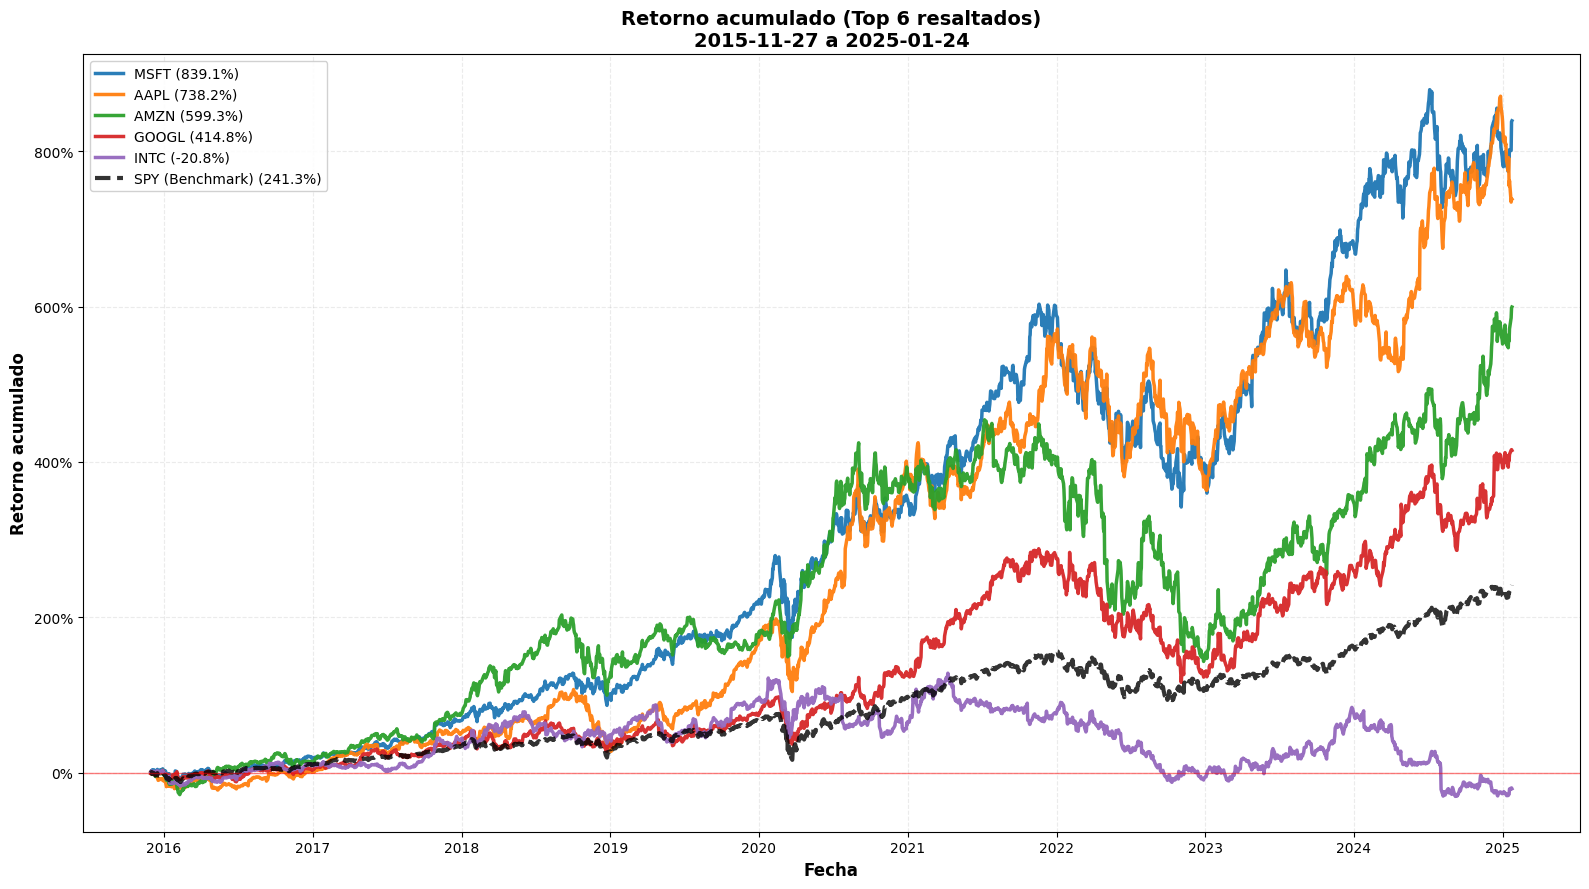

In [6]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#tickers = list(portfolio.keys())
tickers = [t for t in portfolio if t != "NVDA"]

symbols = tickers + market_representation

data = yf.download(symbols, start=training_start_date, end=backtesting_end_date,
                   auto_adjust=True, progress=False)["Close"]

returns = data.pct_change().dropna()
cum = (1 + returns).cumprod() - 1  # acumulado (0.25 = 25%)

# --- ordenar tickers por retorno final ---
last = cum[tickers].iloc[-1].sort_values(ascending=False)
top_n = 6  # ajusta
top = last.index[:top_n]
others = last.index[top_n:]

fig, ax = plt.subplots(figsize=(16, 9))

# resto tenue
for t in others:
    ax.plot(cum.index, cum[t], linewidth=1, alpha=0.25)

# top resaltados
for t in top:
    ax.plot(cum.index, cum[t], linewidth=2.5, alpha=0.95, label=f"{t} ({cum[t].iloc[-1]*100:.1f}%)")

# benchmark
bm = market_representation[0]
if bm in cum.columns:
    ax.plot(cum.index, cum[bm], linewidth=3, linestyle="--", color="black",
            alpha=0.8, label=f"{bm} (Benchmark) ({cum[bm].iloc[-1]*100:.1f}%)")

ax.set_title(f"Retorno acumulado (Top {top_n} resaltados)\n{training_start_date} a {backtesting_end_date}",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Fecha", fontsize=12, fontweight="bold")
ax.set_ylabel("Retorno acumulado", fontsize=12, fontweight="bold")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # 1.0 = 100%
ax.grid(True, alpha=0.25, linestyle="--")
ax.axhline(0, color="red", linewidth=1, alpha=0.5)
ax.legend(loc="upper left", fontsize=10, framealpha=0.9)


plt.tight_layout()
plt.show()


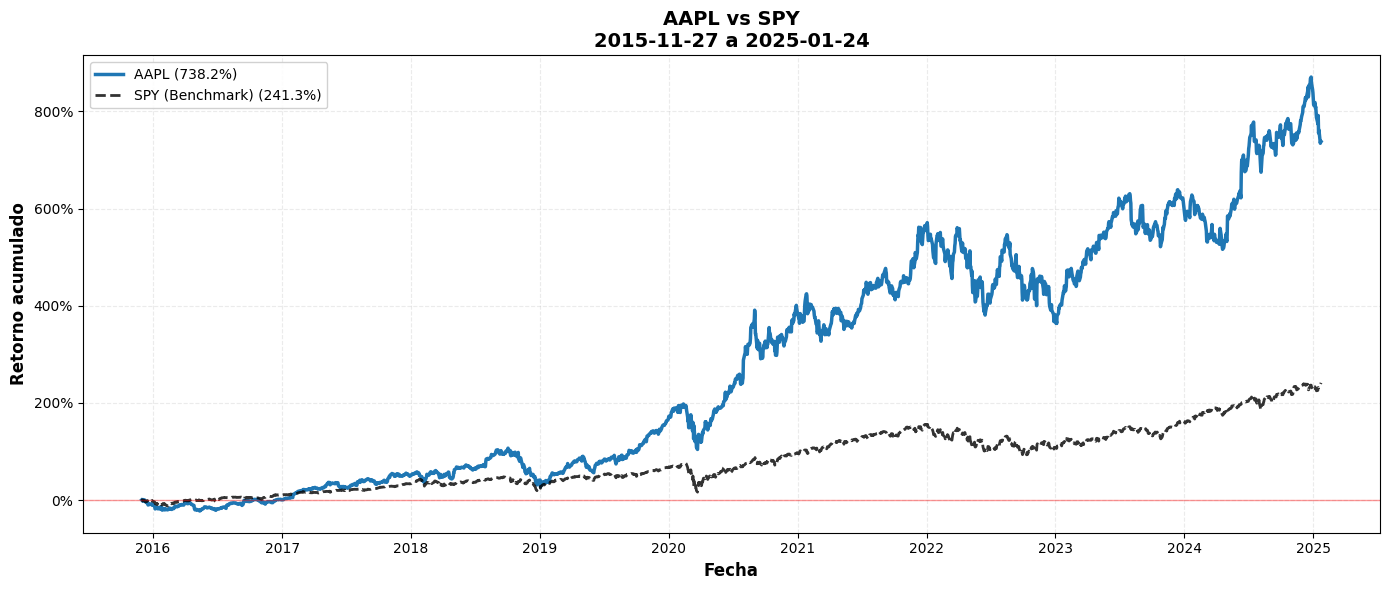

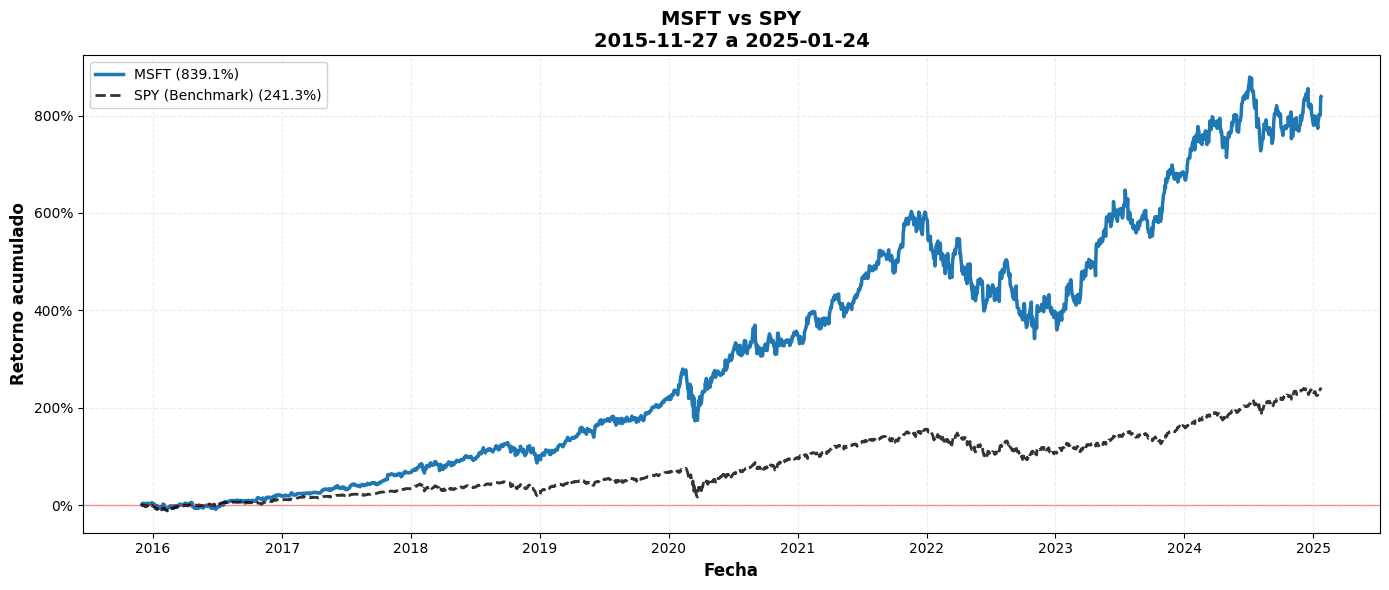

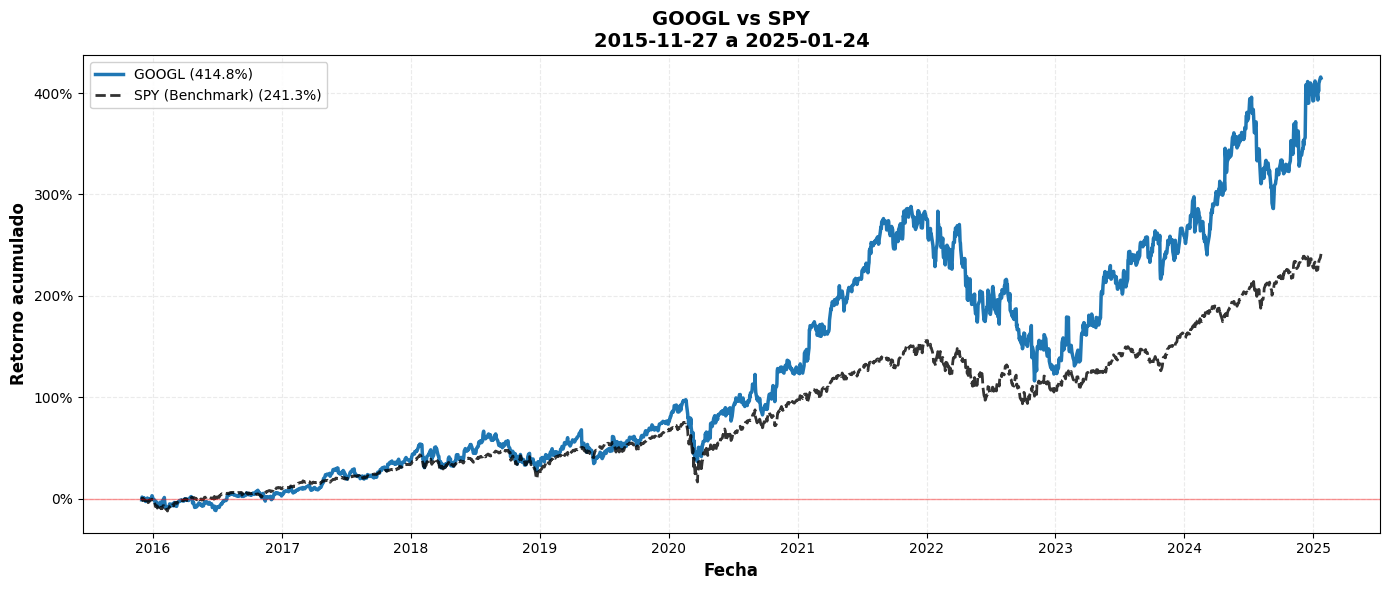

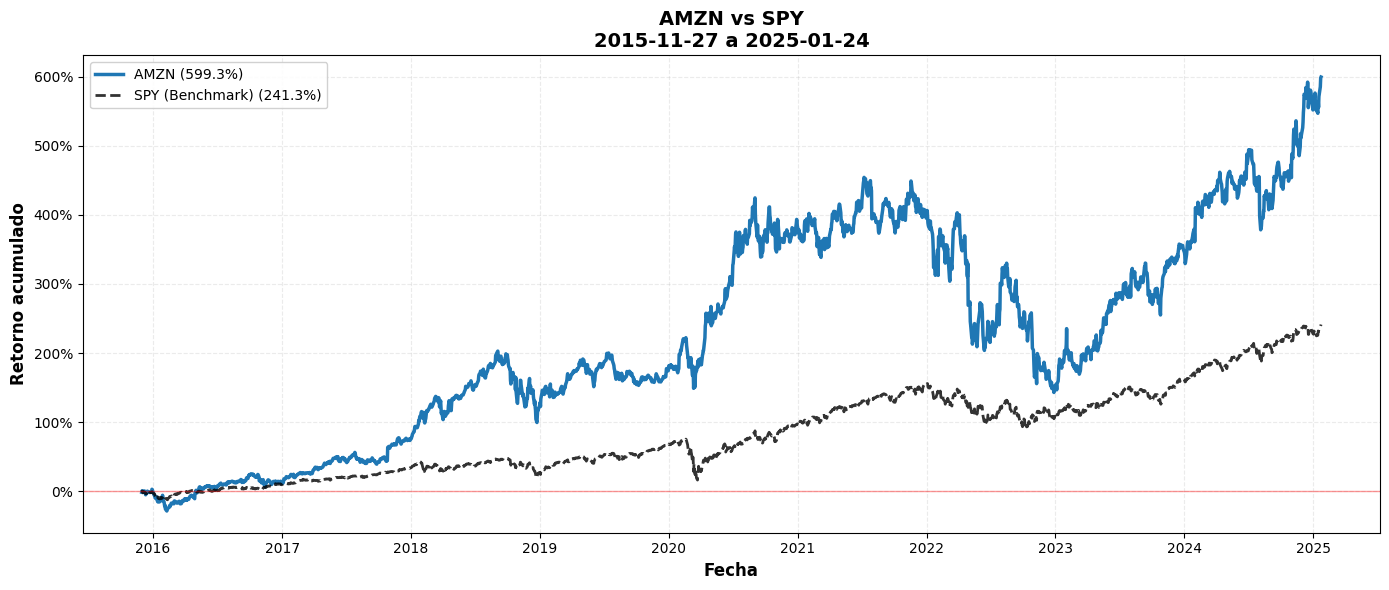

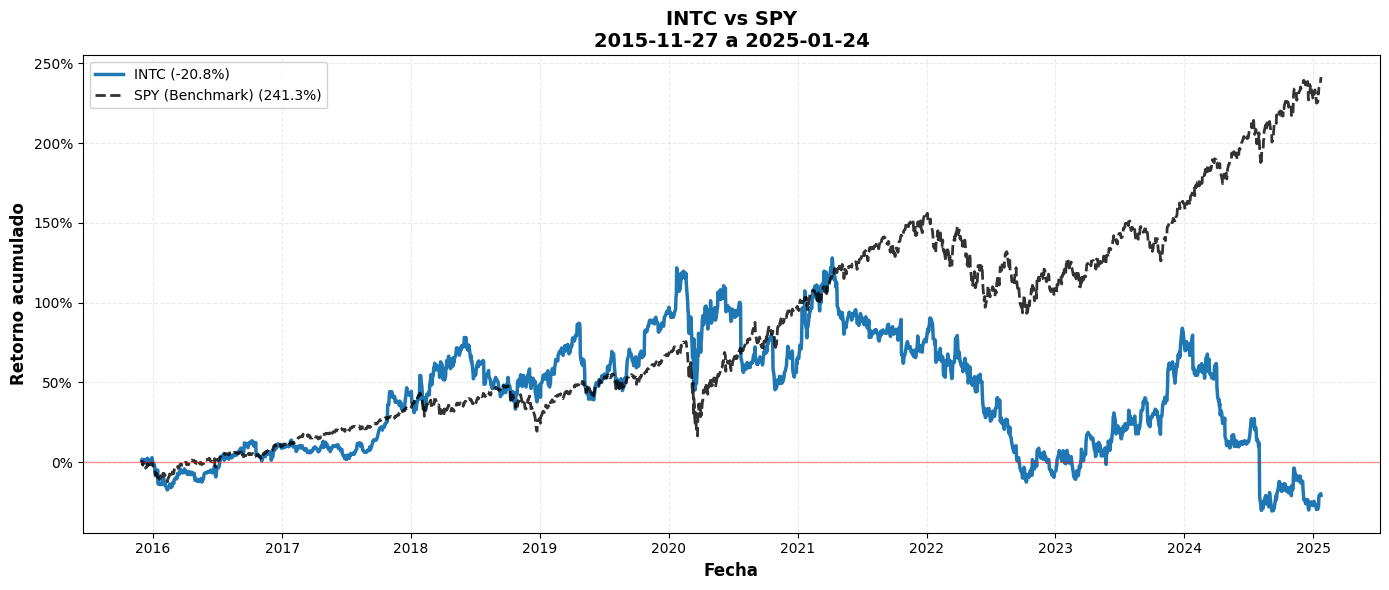

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

bm = market_representation[0]

for t in tickers:
    fig, ax = plt.subplots(figsize=(14, 6))

    ax.plot(cum.index, cum[t], linewidth=2.5, label=f"{t} ({cum[t].iloc[-1]*100:.1f}%)")

    if bm in cum.columns:
        ax.plot(cum.index, cum[bm], linewidth=2, linestyle="--", color="black",
                alpha=0.8, label=f"{bm} (Benchmark) ({cum[bm].iloc[-1]*100:.1f}%)")

    ax.set_title(f"{t} vs {bm}\n{training_start_date} a {backtesting_end_date}",
                 fontsize=14, fontweight="bold")
    ax.set_xlabel("Fecha", fontsize=12, fontweight="bold")
    ax.set_ylabel("Retorno acumulado", fontsize=12, fontweight="bold")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.grid(True, alpha=0.25, linestyle="--")
    ax.axhline(0, color="red", linewidth=1, alpha=0.4)

    ax.legend(loc="upper left", framealpha=0.9)
    plt.tight_layout()
    plt.show()


## 4️⃣ Calcular Pesos Originales del Portafolio

Convertimos las inversiones en dólares a pesos (porcentajes) del portafolio.

In [8]:
# Calcular tickers y pesos originales
tickers, weights = mv.calculate_weights(portfolio)

print("📊 Pesos originales del portafolio:")
weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Peso (%)': [f'{w*100:.2f}%' for w in weights],
    'Inversión ($)': [portfolio[t] for t in tickers]
})
print(weights_df.to_string(index=False))
print(f"\n✅ Total: {sum(weights)*100:.2f}%")

📊 Pesos originales del portafolio:
Ticker Peso (%)  Inversión ($)
  AAPL   13.16%         1500.0
  MSFT   17.54%         2000.0
 GOOGL   15.79%         1800.0
  AMZN   26.32%         3000.0
  NVDA    0.88%          100.0
  INTC   26.32%         3000.0

✅ Total: 100.00%


## 5️⃣ Optimización Mean-Variance (MV) Clásica

Aplicamos la optimización de Markowitz usando solo datos históricos.

In [9]:
print("🔄 Ejecutando optimización Mean-Variance...\n")

# Realizar optimización MV
optimized_weights_mv = mv.mean_variance_optimization(
    tickers, 
    training_start_date, 
    training_end_date, 
    max_volatility, 
    min_weight=min_weight, 
    max_weight=max_weight
)

print("\n✅ Optimización MV completada")
print("\n📊 Comparación: Original vs MV Optimizado")

comparison_mv = pd.DataFrame({
    'Ticker': tickers,
    'Original (%)': [f'{w*100:.2f}%' for w in weights],
    'MV Optimizado (%)': [f'{w*100:.2f}%' for w in optimized_weights_mv],
    'Cambio': [f'{(optimized_weights_mv[i] - weights[i])*100:+.2f}%' for i in range(len(tickers))]
})
print(comparison_mv.to_string(index=False))

🔄 Ejecutando optimización Mean-Variance...



ValueError: attempt to get argmax of an empty sequence

## 6️⃣ Entrenar Modelos de Machine Learning

Usamos XGBoost para generar predicciones de retorno para cada acción.

In [ ]:
import importlib
import sys
sys.modules.pop('machine_learning_strategies', None)

import machine_learning_strategies as mls

pred, conf = mls.generate_investor_views('AAPL', '2013-11-27', '2018-11-27')
print(f"\n📊 Resultado Mejorado:")
print(f"Predicción: {pred*100:.2f}%")
print(f"Confianza: {conf:.3f}  (debe ser > 0.05)")
print(f"Rango válido: {-0.5 <= pred <= 2.0}")

[*********************100%***********************]  1 of 1 completed

  ✅ AAPL: Weekly Return: 0.407%, Annual Return: 23.54%, Confidence (R²): 0.397, Train samples: 842, Test samples: 362

📊 Resultado Mejorado:
Predicción: 23.54%
Confianza: 0.397  (debe ser > 0.05)
Rango válido: True


In [ ]:
print("🤖 Entrenando modelos de Machine Learning...\n")

investor_views = {}
view_confidences = {}

# Entrenar un modelo ML para cada ticker
for i, ticker in enumerate(tickers, 1):
    print(f"[{i}/{len(tickers)}] Entrenando modelo para {ticker}...", end=" ")
    investor_views[ticker], view_confidences[ticker] = mls.generate_investor_views(
        ticker, 
        training_start_date, 
        training_end_date
    )
    print(f"✅ Retorno predicho: {investor_views[ticker]*100:.2f}%, Confianza: {view_confidences[ticker]:.2f}")

print("\n✅ Todos los modelos ML entrenados")

[*********************100%***********************]  1 of 1 completed

🤖 Entrenando modelos de Machine Learning...

[1/6] Entrenando modelo para AAPL...   ✅ AAPL: Weekly Return: 0.407%, Annual Return: 23.54%, Confidence (R²): 0.397, Train samples: 842, Test samples: 362
✅ Retorno predicho: 23.54%, Confianza: 0.40
[2/6] Entrenando modelo para MSFT... 


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  ✅ MSFT: Weekly Return: 0.576%, Annual Return: 34.82%, Confidence (R²): 0.352, Train samples: 842, Test samples: 362
✅ Retorno predicho: 34.82%, Confianza: 0.35
[3/6] Entrenando modelo para GOOGL...   ✅ GOOGL: Weekly Return: 0.211%, Annual Return: 11.58%, Confidence (R²): 0.326, Train samples: 842, Test samples: 362
✅ Retorno predicho: 11.58%, Confianza: 0.33
[4/6] Entrenando modelo para AMZN... 


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  ✅ AMZN: Weekly Return: 0.486%, Annual Return: 28.67%, Confidence (R²): 0.438, Train samples: 842, Test samples: 362
✅ Retorno predicho: 28.67%, Confianza: 0.44
[5/6] Entrenando modelo para NVDA...   ✅ NVDA: Weekly Return: 0.924%, Annual Return: 61.29%, Confidence (R²): 0.457, Train samples: 842, Test samples: 362
✅ Retorno predicho: 61.29%, Confianza: 0.46
[6/6] Entrenando modelo para INTC... 

  ✅ INTC: Weekly Return: 0.278%, Annual Return: 15.52%, Confidence (R²): 0.473, Train samples: 842, Test samples: 362
✅ Retorno predicho: 15.52%, Confianza: 0.47

✅ Todos los modelos ML entrenados


## 7️⃣ Aplicar Modelo Black-Litterman

Combinamos las predicciones ML con el equilibrio del mercado.

In [ ]:
print("🔄 Aplicando modelo Black-Litterman...\n")

# Obtener capitalizaciones de mercado
market_caps = bl.get_market_caps(tickers)

# Descargar datos del índice de mercado
index_data = mv.download_stock_data(market_representation, training_start_date, training_end_date)

# Manejar caso donde index_data['Adj Close'] puede ser DataFrame o Series
adj_close = index_data['Adj Close']
if isinstance(adj_close, pd.DataFrame):
    adj_close = adj_close.iloc[:, 0]  # Tomar primera columna si es DataFrame

# Calcular retorno como escalar
index_return = (adj_close.iloc[-1] / adj_close.iloc[0]) - 1

# Convertir a escalar si es Series
if isinstance(index_return, pd.Series):
    index_return = index_return.iloc[0]

print(f"📊 Retorno del mercado ({market_representation[0]}): {index_return*100:.2f}%")

# Calcular retornos de mercado para cada activo
market_returns = bl.get_market_returns(market_caps, index_return)

# Descargar datos históricos
historical_data = mv.download_stock_data(tickers, training_start_date, training_end_date)

# Aplicar ajuste Black-Litterman
predicted_returns = bl.black_litterman_adjustment(
    market_returns, 
    investor_views, 
    view_confidences, 
    historical_data
)

# Mapear retornos ajustados a tickers
predicted_returns = dict(zip(tickers, predicted_returns))

print("\n✅ Ajuste Black-Litterman completado")
print("\n📊 Retornos ajustados:")
for ticker in tickers:
    print(f"  {ticker}: {predicted_returns[ticker]*100:.2f}%")

🔄 Aplicando modelo Black-Litterman...

📊 Retorno del mercado (SPY): 63.01%

✅ Ajuste Black-Litterman completado

📊 Retornos ajustados:
  AAPL: 12.52%
  MSFT: 11.84%
  GOOGL: 13.57%
  AMZN: 8.74%
  NVDA: 15.61%
  INTC: 0.78%


## 8️⃣ Optimización ML + Mean-Variance

Aplicamos Mean-Variance usando los retornos predichos por ML y ajustados por Black-Litterman.

In [ ]:
print("🔄 Ejecutando optimización ML + Mean-Variance...\n")

# Convertir retornos ajustados al formato esperado
adjusted_returns_vector = np.array([predicted_returns[ticker] for ticker in tickers])

# Realizar optimización con retornos predichos
optimized_weights_ml_mv = mv.mean_variance_optimization(
    tickers, 
    training_start_date, 
    training_end_date, 
    max_volatility, 
    adjusted_returns_vector, 
    min_weight, 
    max_weight
)

print("\n✅ Optimización ML + MV completada")

🔄 Ejecutando optimización ML + Mean-Variance...


✅ Optimización ML + MV completada


## 9️⃣ Comparación de los 3 Portafolios

Comparamos los pesos de las 3 estrategias.

In [ ]:
# Convertir pesos a porcentajes
weights_pct = [f'{weight * 100:.2f}%' for weight in weights]
optimized_weights_pct = [f'{weight * 100:.2f}%' for weight in optimized_weights_mv]
optimized_weights_with_adjusted_returns_pct = [f'{weight * 100:.2f}%' for weight in optimized_weights_ml_mv]

# Crear DataFrame de comparación
portfolio_comparison = pd.DataFrame({
    'Original': weights_pct,
    'MV Optimization': optimized_weights_pct, 
    'ML MV Optimization': optimized_weights_with_adjusted_returns_pct
}, index=tickers)

print("📊 COMPARACIÓN DE PESOS DEL PORTAFOLIO")
print("="*70)
print(portfolio_comparison)
print("="*70)

# Análisis de cambios
print("\n📈 Cambios principales en ML + MV vs Original:")
for i, ticker in enumerate(tickers):
    change = (optimized_weights_ml_mv[i] - weights[i]) * 100
    if abs(change) > 2:  # Mostrar solo cambios significativos
        emoji = "⬆️" if change > 0 else "⬇️"
        print(f"  {emoji} {ticker}: {change:+.2f}% ({weights[i]*100:.2f}% → {optimized_weights_ml_mv[i]*100:.2f}%)")

📊 COMPARACIÓN DE PESOS DEL PORTAFOLIO
      Original MV Optimization ML MV Optimization
AAPL    13.16%          12.96%             20.80%
MSFT    17.54%          24.54%              6.81%
GOOGL   15.79%           2.31%             30.30%
AMZN    26.32%           1.72%              3.26%
NVDA     0.88%          29.41%             36.53%
INTC    26.32%          29.05%              2.29%

📈 Cambios principales en ML + MV vs Original:
  ⬆️ AAPL: +7.64% (13.16% → 20.80%)
  ⬇️ MSFT: -10.73% (17.54% → 6.81%)
  ⬆️ GOOGL: +14.51% (15.79% → 30.30%)
  ⬇️ AMZN: -23.06% (26.32% → 3.26%)
  ⬆️ NVDA: +35.65% (0.88% → 36.53%)
  ⬇️ INTC: -24.02% (26.32% → 2.29%)


## 🔟 Backtesting: Validación Histórica

Probamos cómo hubieran funcionado las 3 estrategias en el periodo 2018-2023.

In [ ]:
print("🔄 Descargando datos de backtesting...\n")

# Descargar datos de mercado para backtesting (con auto_adjust=False)
historical_data_backtest = mv.download_stock_data(tickers, backtesting_start_date, backtesting_end_date)

# DIAGNÓSTICO: Ver estructura completa del DataFrame
print("🔍 DIAGNÓSTICO DEL DATAFRAME:")
print(f"Tipo de índice de columnas: {type(historical_data_backtest.columns)}")
print(f"Columnas nivel 0: {historical_data_backtest.columns.levels[0].tolist() if isinstance(historical_data_backtest.columns, pd.MultiIndex) else 'No es MultiIndex'}")
print(f"Primeras 5 columnas: {historical_data_backtest.columns.tolist()[:5]}")
print(f"Shape: {historical_data_backtest.shape}")
print(f"\nPrimeras columnas completas:")
for i, col in enumerate(historical_data_backtest.columns[:10]):
    print(f"  [{i}] {col}")

# Intentar acceder a Adj Close de diferentes maneras
try:
    if isinstance(historical_data_backtest.columns, pd.MultiIndex):
        # MultiIndex: ('Adj Close', 'AAPL'), ('Adj Close', 'JNJ'), ...
        print("\n✅ Detectado MultiIndex")
        daily_returns_backtest = historical_data_backtest['Adj Close'].pct_change()
    else:
        # No MultiIndex, acceso directo
        print("\n✅ Detectado columnas simples")
        daily_returns_backtest = historical_data_backtest['Adj Close'].pct_change()
    
    print(f"✅ Datos extraídos correctamente")
    print(f"📅 Periodo: {backtesting_start_date} a {backtesting_end_date}")
    print(f"📊 Registros: {len(daily_returns_backtest)} días")
    print(f"📈 Tickers analizados: {', '.join(tickers)}")
    
except KeyError as e:
    print(f"\n❌ ERROR: {e}")
    print(f"Las columnas disponibles son: {historical_data_backtest.columns.tolist()}")
    print("\nIntentando método alternativo...")
    
    # Método alternativo: usar directamente sin especificar 'Adj Close'
    if isinstance(historical_data_backtest.columns, pd.MultiIndex):
        # Si es MultiIndex pero no tiene Adj Close, buscar Close
        if 'Close' in historical_data_backtest.columns.levels[0]:
            print("Usando 'Close' en lugar de 'Adj Close'")
            daily_returns_backtest = historical_data_backtest['Close'].pct_change()
        else:
            raise Exception("No se encontró ni 'Adj Close' ni 'Close'")
    else:
        # Último recurso
        daily_returns_backtest = historical_data_backtest.pct_change()
    
    print(f"✅ Datos extraídos con método alternativo")
    print(f"📊 Registros: {len(daily_returns_backtest)} días")

🔄 Descargando datos de backtesting...

🔍 DIAGNÓSTICO DEL DATAFRAME:
Tipo de índice de columnas: <class 'pandas.MultiIndex'>
Columnas nivel 0: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
Primeras 5 columnas: [('Adj Close', 'AAPL'), ('Adj Close', 'AMZN'), ('Adj Close', 'GOOGL'), ('Adj Close', 'INTC'), ('Adj Close', 'MSFT')]
Shape: (1547, 36)

Primeras columnas completas:
  [0] ('Adj Close', 'AAPL')
  [1] ('Adj Close', 'AMZN')
  [2] ('Adj Close', 'GOOGL')
  [3] ('Adj Close', 'INTC')
  [4] ('Adj Close', 'MSFT')
  [5] ('Adj Close', 'NVDA')
  [6] ('Close', 'AAPL')
  [7] ('Close', 'AMZN')
  [8] ('Close', 'GOOGL')
  [9] ('Close', 'INTC')

✅ Detectado MultiIndex
✅ Datos extraídos correctamente
📅 Periodo: 2018-11-27 a 2025-01-24
📊 Registros: 1547 días
📈 Tickers analizados: AAPL, MSFT, GOOGL, AMZN, NVDA, INTC


### Calcular Retornos Acumulados

In [ ]:
print("📈 Calculando retornos acumulados...\n")

# 1. Portafolio ML + MV optimizado
portfolio_returns_ml_mv = daily_returns_backtest.dot(optimized_weights_ml_mv)
cumulative_returns_ml_mv = (1 + portfolio_returns_ml_mv).cumprod()

# 2. Portafolio MV optimizado
portfolio_returns_mv = daily_returns_backtest.dot(optimized_weights_mv)
cumulative_returns_mv = (1 + portfolio_returns_mv).cumprod()

# 3. Portafolio original sin optimizar
portfolio_returns_unoptimized = daily_returns_backtest.dot(weights)
cumulative_returns_unoptimized = (1 + portfolio_returns_unoptimized).cumprod()

# 4. Mercado (benchmark SPY) - ahora con auto_adjust=False garantiza Adj Close
market_data_raw = mv.download_stock_data(market_representation, backtesting_start_date, backtesting_end_date)
market_data = market_data_raw['Adj Close']

# Si hay MultiIndex (un solo ticker debería ser Series, no DataFrame)
if isinstance(market_data, pd.DataFrame):
    market_data = market_data.iloc[:, 0]  # Tomar primera columna

market_returns = market_data.pct_change()
cumulative_market_returns = (1 + market_returns).cumprod()

print("✅ Retornos calculados")
print("\n📊 Retorno total en el periodo:")
print(f"  🤖 ML + MV Optimizado:       {(cumulative_returns_ml_mv.iloc[-1] - 1)*100:+.2f}%")
print(f"  📈 MV Optimizado:            {(cumulative_returns_mv.iloc[-1] - 1)*100:+.2f}%")
print(f"  📊 Mercado (SPY):            {(cumulative_market_returns.iloc[-1] - 1)*100:+.2f}%")
print(f"  📉 Original (sin optimizar): {(cumulative_returns_unoptimized.iloc[-1] - 1)*100:+.2f}%")

📈 Calculando retornos acumulados...

✅ Retornos calculados

📊 Retorno total en el periodo:
  🤖 ML + MV Optimizado:       +353.36%
  📈 MV Optimizado:            +754.05%
  📊 Mercado (SPY):            +151.13%
  📉 Original (sin optimizar): +403.87%


## 1️⃣1️⃣ Calcular Métricas de Desempeño

Calculamos Sharpe Ratio, Sortino Ratio e Information Ratio para cada estrategia.

In [ ]:
print("📊 Calculando métricas de desempeño...\n")

# Métricas para ML + MV optimizado
sharpe_ratio_ml_mv = ps.sharpe_ratio(portfolio_returns_ml_mv, risk_free_rate)
sortino_ratio_ml_mv = ps.sortino_ratio(portfolio_returns_ml_mv, risk_free_rate)
info_ratio_ml_mv = ps.information_ratio(portfolio_returns_ml_mv, market_returns)

# Métricas para MV optimizado
sharpe_ratio_mv = ps.sharpe_ratio(portfolio_returns_mv, risk_free_rate)
sortino_ratio_mv = ps.sortino_ratio(portfolio_returns_mv, risk_free_rate)
info_ratio_mv = ps.information_ratio(portfolio_returns_mv, market_returns)

# Métricas para portafolio original
sharpe_ratio_unoptimized = ps.sharpe_ratio(portfolio_returns_unoptimized, risk_free_rate)
sortino_ratio_unoptimized = ps.sortino_ratio(portfolio_returns_unoptimized, risk_free_rate)
info_ratio_unoptimized = ps.information_ratio(portfolio_returns_unoptimized, market_returns)

# Métricas para el mercado
sharpe_ratio_market = ps.sharpe_ratio(market_returns, risk_free_rate)
sortino_ratio_market = ps.sortino_ratio(market_returns, risk_free_rate)
info_ratio_market = ps.information_ratio(market_returns, market_returns)

print("✅ Métricas calculadas")

# Crear tabla comparativa
metrics_comparison = pd.DataFrame({
    'Estrategia': ['ML + MV Optimizado', 'MV Optimizado', 'Mercado (SPY)', 'Original'],
    'Sharpe Ratio': [sharpe_ratio_ml_mv, sharpe_ratio_mv, sharpe_ratio_market, sharpe_ratio_unoptimized],
    'Sortino Ratio': [sortino_ratio_ml_mv, sortino_ratio_mv, sortino_ratio_market, sortino_ratio_unoptimized],
    'Info Ratio': [info_ratio_ml_mv, info_ratio_mv, info_ratio_market, info_ratio_unoptimized],
    'Retorno Total (%)': [
        (cumulative_returns_ml_mv.iloc[-1] - 1)*100,
        (cumulative_returns_mv.iloc[-1] - 1)*100,
        (cumulative_market_returns.iloc[-1] - 1)*100,
        (cumulative_returns_unoptimized.iloc[-1] - 1)*100
    ]
})

print("\n📊 TABLA COMPARATIVA DE MÉTRICAS")
print("="*90)
print(metrics_comparison.to_string(index=False))
print("="*90)

📊 Calculando métricas de desempeño...

✅ Métricas calculadas

📊 TABLA COMPARATIVA DE MÉTRICAS
        Estrategia  Sharpe Ratio  Sortino Ratio  Info Ratio  Retorno Total (%)
ML + MV Optimizado      0.892540       1.448067    1.039084         353.357103
     MV Optimizado      1.122801       1.861243    1.247411         754.051503
     Mercado (SPY)      0.652438       1.005716    0.852992         151.134704
          Original      0.857427       1.401059    0.981859         403.872909


## 1️⃣2️⃣ Visualización: Comparación de Retornos

Graficamos los retornos acumulados de las 4 estrategias.

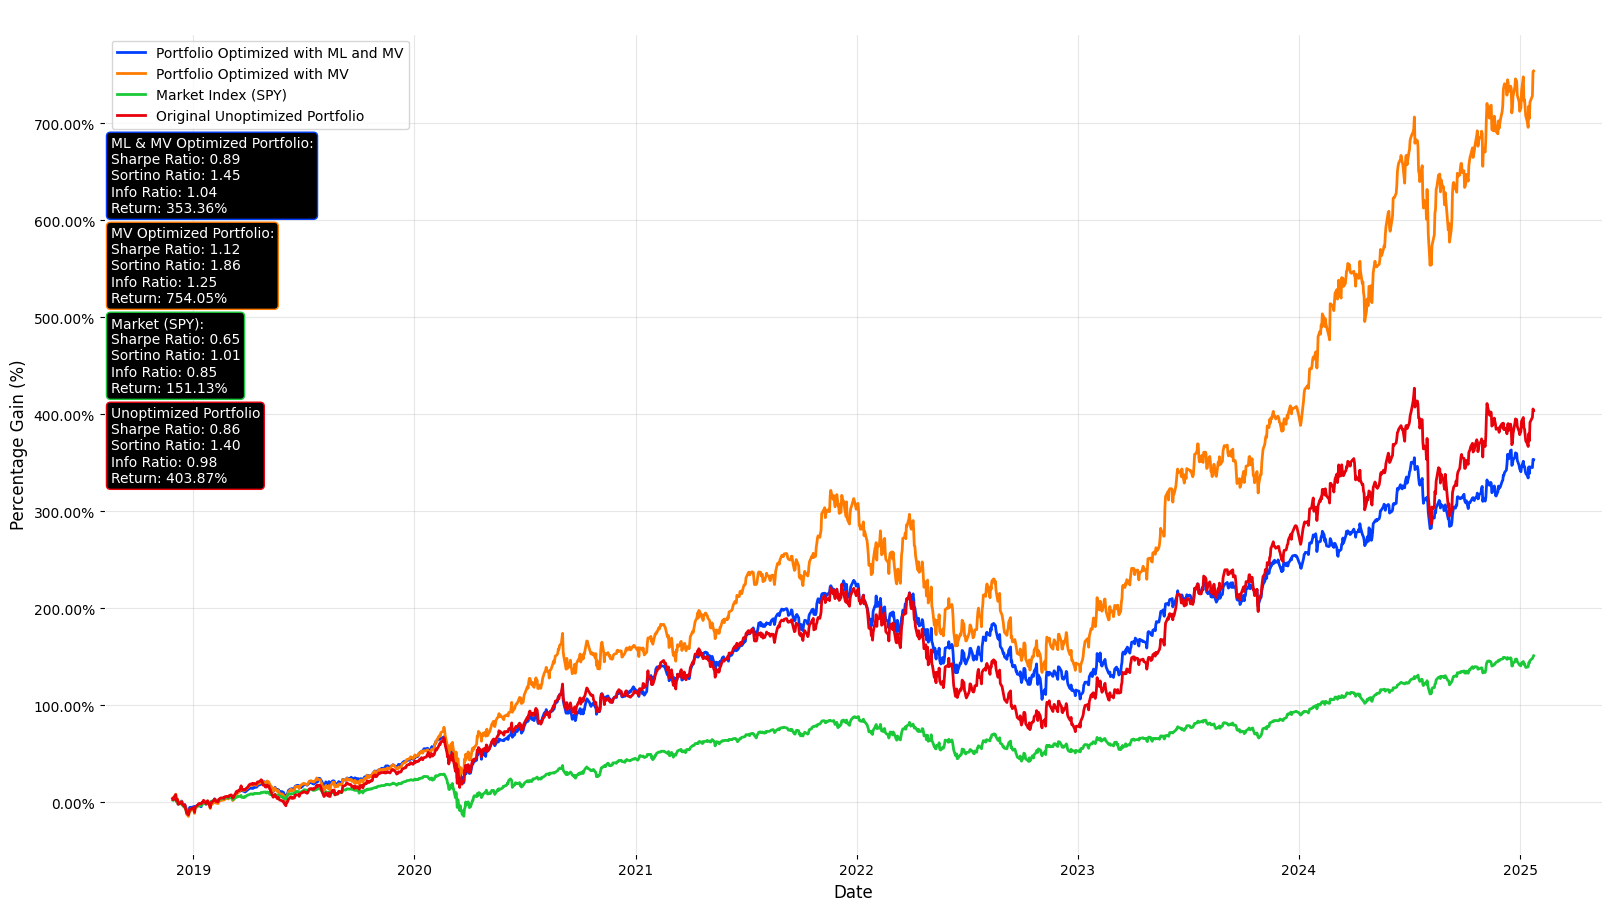


✅ Gráfico generado


In [27]:
# Convertir retornos a porcentaje
cumulative_returns_ml_mv_percent = (cumulative_returns_ml_mv - 1) * 100
cumulative_returns_mv_percent = (cumulative_returns_mv - 1) * 100
cumulative_returns_unoptimized_percent = (cumulative_returns_unoptimized - 1) * 100
cumulative_market_returns_percent = (cumulative_market_returns - 1) * 100

# Obtener retornos finales
final_returns_ml_mv = cumulative_returns_ml_mv_percent.iloc[-1]
final_returns_mv = cumulative_returns_mv_percent.iloc[-1]
final_returns_unoptimized = cumulative_returns_unoptimized_percent.iloc[-1]
final_returns_market = cumulative_market_returns_percent.iloc[-1]

# Configurar figura
plt.figure(figsize=(16, 9), constrained_layout=True)
ax = plt.gca()

# Configurar colores
sns.set_palette("bright")
colors = sns.color_palette()

# Estética del gráfico
plt.gcf().set_facecolor('white')
ax.set_facecolor('white')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2f}%'.format(y)))

for spine in ax.spines.values():
    spine.set_edgecolor('white')

# Graficar líneas
plt.plot(cumulative_returns_ml_mv_percent, label='Portfolio Optimized with ML and MV', color=colors[0], linewidth=2)
plt.plot(cumulative_returns_mv_percent, label='Portfolio Optimized with MV', color=colors[1], linewidth=2)
plt.plot(cumulative_market_returns_percent, label='Market Index (SPY)', color=colors[2], linewidth=2)
plt.plot(cumulative_returns_unoptimized_percent, label='Original Unoptimized Portfolio', color=colors[3], linewidth=2)

# Cajas de estadísticas
stats_text_ml_mv = f"ML & MV Optimized Portfolio:\nSharpe Ratio: {sharpe_ratio_ml_mv:.2f}\nSortino Ratio: {sortino_ratio_ml_mv:.2f}\nInfo Ratio: {info_ratio_ml_mv:.2f}\nReturn: {final_returns_ml_mv:.2f}%"
plt.text(x=0.0655, y=0.77, s=stats_text_ml_mv, transform=plt.gcf().transFigure, fontsize=10, color='white', bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[0], facecolor='black'))

stats_text_mv = f"MV Optimized Portfolio:\nSharpe Ratio: {sharpe_ratio_mv:.2f}\nSortino Ratio: {sortino_ratio_mv:.2f}\nInfo Ratio: {info_ratio_mv:.2f}\nReturn: {final_returns_mv:.2f}%"
plt.text(x=0.0655, y=0.67, s=stats_text_mv, transform=plt.gcf().transFigure, fontsize=10, color='white', bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[1], facecolor='black'))

stats_text_unoptimized = f"Market ({market_representation[0]}):\nSharpe Ratio: {sharpe_ratio_market:.2f}\nSortino Ratio: {sortino_ratio_market:.2f}\nInfo Ratio: {info_ratio_market:.2f}\nReturn: {final_returns_market:.2f}%"
plt.text(x=0.0655, y=0.57, s=stats_text_unoptimized, transform=plt.gcf().transFigure, fontsize=10, color='white', bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[2], facecolor='black'))

stats_text_market = f"Unoptimized Portfolio\nSharpe Ratio: {sharpe_ratio_unoptimized:.2f}\nSortino Ratio: {sortino_ratio_unoptimized:.2f}\nInfo Ratio: {info_ratio_unoptimized:.2f}\nReturn: {final_returns_unoptimized:.2f}%"
plt.text(x=0.0655, y=0.47, s=stats_text_market, transform=plt.gcf().transFigure, fontsize=10, color='white', bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[3], facecolor='black'))

plt.title('Comparative Cumulative Returns', color='white', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage Gain (%)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ Gráfico generado")

## 🎯 Conclusiones

### Interpretación de Resultados

1. **Sharpe Ratio**: Mayor es mejor (retorno por unidad de riesgo)
2. **Sortino Ratio**: Mayor es mejor (retorno por unidad de riesgo negativo)
3. **Information Ratio**: Mayor es mejor (exceso de retorno vs mercado)

### Recomendaciones

Basado en los resultados del backtesting:
- Si ML + MV tuvo mejor desempeño → Considera rebalancear según esos pesos
- Revisa qué acciones aumentar/reducir
- Evalúa si el nivel de riesgo (volatilidad) se ajusta a tu perfil

### ⚠️ Advertencia

**Rendimientos pasados no garantizan resultados futuros.** Este análisis es solo una herramienta de apoyo para toma de decisiones informadas. Consulta con un asesor financiero profesional antes de realizar cambios en tu portafolio.